# Getting the PCA code to slice the point set into 3 sections: top, middle, basal 
This is transformation of a single frame from a single video from the dataset. Just use a segmentation from the dataset, no need to use the model to segment a video.

In [1]:
%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
# from src.utils.echo_utils import get2dPucks ### We are using a debugging version!!
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset

from src.misc import load_model_by_name
# from src.visualization_utils import categorical_dice


import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)

In [2]:
%matplotlib widget
from src.strain import *

In [3]:
batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}

In [4]:
with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.04it/s]


In [6]:
test_pat_index = 0

video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]

In [7]:
I = es_label

I_regional_point_sets = image_to_regional_point_sets(I)

/home/wmw015/summer2022research/echo_22/dev/longitudinal_strain/src/strain.py:1019: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  multichannel=False)
/home/wmw015/summer2022research/echo_22/dev/longitudinal_strain/src/strain.py:1156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  I_regional_point_sets = np.array(I_regional_point_sets)


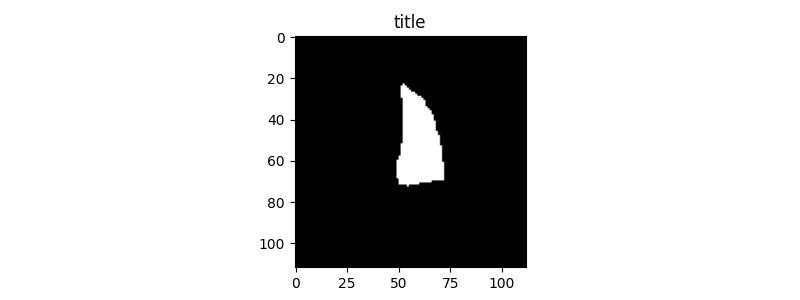

In [8]:
vis_single(I, cmap='gray')

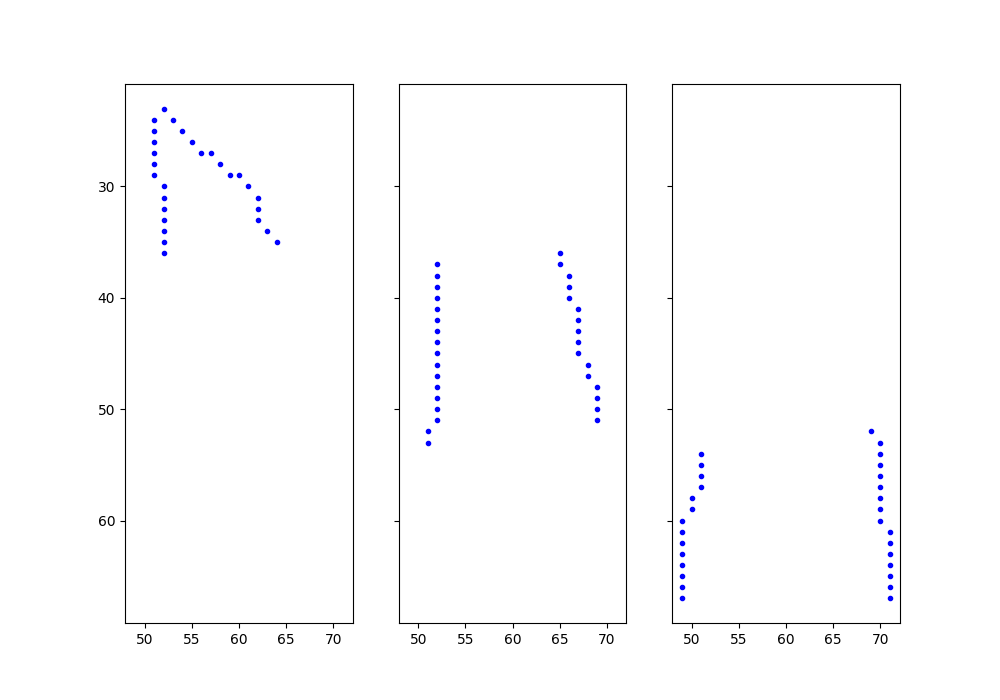

In [9]:
vis_three_point_sets(I_regional_point_sets)